In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import math
import time
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

# local python package
sys.path.append(os.path.join(os.getcwd(), '..'))
from voc_loader import VOC_loader
import fcn_vgg
from loss import loss as get_loss
from utils.utils import *
from utils.tf_utils import *

slim = tf.contrib.slim

In [2]:
def plot_result(img, gt_seg, pred_seg, palette):
    if pred_seg is None:
        f, (ax1, ax2) = plt.subplots(1, 2)
    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
    ax1.imshow(img.astype(np.uint8))
    ax2.imshow(gt_seg.astype(np.uint8))
    
    if pred_seg is not None:
        np.place(pred_seg, pred_seg == 21, 255)
        tmp = Image.fromarray(pred_seg.astype(np.uint8), 'P')
        tmp.putpalette(palette)
        ax3.imshow(tmp)
    
    plt.show()

## Download VOC 2012 dataset

In [ ]:
if not os.path.exists('VOCdevkit'):
    os.system('wget http://cvlab.postech.ac.kr/~jonghwan/VOC2012.tar')
    os.system('tar xvf VOC2012.tar')
    os.system('rm VOC2012.tar')

data_dir = 'vgg_models'
data_url = 'http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz'
maybe_download_and_extract(data_url, data_dir, 'vgg_16.ckpt')`

### Create loader

In [99]:
loader_params = {
    'num_classes': 22,
    'image_size': 448,
    'split_root': 'VOCdevkit/VOC2012/ImageSets/Segmentation',
    'image_root': 'VOCdevkit/VOC2012/JPEGImages',
    'segmap_root': 'VOCdevkit/VOC2012/SegmentationClass',
}
loader = VOC_loader(loader_params)

# get information for VOC
class_names = loader.get_class_names()
num_classes = loader_params['num_classes']
img_size = loader_params['image_size']

### Check the dataset

In [ ]:
batch = loader.get_batch(10)

In [ ]:
bi = np.random.randint(10)
plot_result(batch['images'][bi], batch['seg_maps'][bi], 
            None, loader.get_palette())

### Create deconvolution with bilinear filter

In [12]:
import skimage.transform

In [152]:
def _get_bilinear_filter(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    # TODO 2: compute bilinear filter given the size
    
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    #return bilinear_filter


def _get_bilinear_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    filter_size = 2 * factor - factor % 2
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = _get_bilinear_filter(filter_size)
    
    for i in xrange(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    
    init = tf.constant_initializer(value=weights,
                                   dtype=tf.float32)
    return tf.get_variable(name="up_filter", initializer=init,
                           shape=weights.shape)

# reset the graph and session
tf.reset_default_graph()
sess.close()

img = tf.placeholder(tf.float32)

factor = 3
weight = _get_bilinear_weights(factor, 1)
inp = np.zeros((1,2,2,1)).astype(np.float32)
inp[0,:,:,0] = np.arange(1,5).reshape((2,2))[:]
resized_img = tf.nn.conv2d_transpose(inp, weight, 
                                    #output_shape=[1, img_size*factor, 
                                    #              img_size*factor, 3],
                                     output_shape=[1,6,6,1],
                                    strides=[1,factor,factor,1], padding='SAME')


batch = loader.get_batch(1, 'train')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tf_resized_img = sess.run(resized_img, 
                          feed_dict={img:batch['images']})

In [147]:
print(np.arange(1,5).reshape((2,2)))

[[1 2]
 [3 4]]


In [153]:
# show bilinear filter
tf_w = weight.eval(sess)[:,:,0,0]
for i in range(tf_w.shape[0]):
    ith_w = ''
    for j in range(tf_w.shape[1]):
        ith_w += '%.3f' % tf_w[i,j] + ' '
    print(ith_w)

0.111 0.222 0.333 0.222 0.111 
0.222 0.444 0.667 0.444 0.222 
0.333 0.667 1.000 0.667 0.333 
0.222 0.444 0.667 0.444 0.222 
0.111 0.222 0.333 0.222 0.111 


In [160]:
print(tf_resized_img[0].transpose())
print(tf_resized_img[0,:,:,0])

[[[ 0.44444445  0.66666669  1.11111116  1.55555558  2.          1.33333337]
  [ 0.66666669  1.          1.66666675  2.33333325  3.          2.        ]
  [ 0.8888889   1.33333337  2.          2.66666675  3.33333349  2.22222233]
  [ 1.11111116  1.66666675  2.33333349  3.          3.66666675  2.44444442]
  [ 1.33333337  2.          2.66666675  3.33333349  4.          2.66666675]
  [ 0.8888889   1.33333337  1.77777779  2.22222233  2.66666675  1.77777779]]]
[[ 0.44444445  0.66666669  0.8888889   1.11111116  1.33333337  0.8888889 ]
 [ 0.66666669  1.          1.33333337  1.66666675  2.          1.33333337]
 [ 1.11111116  1.66666675  2.          2.33333349  2.66666675  1.77777779]
 [ 1.55555558  2.33333325  2.66666675  3.          3.33333349  2.22222233]
 [ 2.          3.          3.33333349  3.66666675  4.          2.66666675]
 [ 1.33333337  2.          2.22222233  2.44444442  2.66666675  1.77777779]]


In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(batch['images'][0].astype(np.uint8))
ax2.imshow(tf_resized_img[0].astype(np.uint8))
ax3.imshow(np.array(skimage.transform.rescale(batch['images'][0],
                                    factor, mode='constant',
                                    cval=0, order=1), dtype=np.uint8))
plt.show()

In [116]:
# reset the graph and session
tf.reset_default_graph()
sess.close()

### Parameters

In [117]:
# Model updating parameters
lr_params = {}
lr_params['initial_lr'] = 0.0001
lr_params['decay_step'] = 10000
lr_params['decay_rate'] = 0.8

batch_size = 16
num_epochs = 50

iteration_per_epoch = int(math.floor(loader.get_num_train_examples() / batch_size))
save_checkpoint_frequency = 100
print_frequency = 10

checkpoint_path = ''
net_type = 'fcn_32s'
save_path = '%s_checkpoints' % net_type
save_model = ( save_path + '/%s_vgg') % net_type
if not os.path.exists(save_path): os.makedirs(save_path)

## Build FCN

In [120]:
#with tf.Session() as sess:
with tf.variable_scope('inputs') as scope:
    images = tf.placeholder(dtype=tf.float32, 
                            shape=[batch_size, img_size, img_size, 3],
                            name='images')
    labels = tf.placeholder(dtype=tf.int64, 
                            shape=[batch_size, img_size, img_size], 
                            name='labels')

# build FCN
vgg_fcn = fcn_vgg.FCN()
vgg_fcn.build(images, net_type=net_type, train=True, num_classes=22, debug=False)

# Set the variables to be restored
include_layers = ['vgg_16/conv1', 'vgg_16/conv2', 'vgg_16/conv3', 'vgg_16/conv4',
                 'vgg_16/conv5', 'vgg_16/fc6', 'vgg_16/fc7']
variables_to_restore = slim.get_variables_to_restore(include=include_layers)
print('===> The list of variables to be restored:')
for i in variables_to_restore: print(i.op.name)
    
# optimizer
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
lr = tf.train.exponential_decay(lr_params['initial_lr'],
                                global_step,
                                lr_params['decay_step'],
                                lr_params['decay_rate'],
                                staircase=True)
total_loss = get_loss(vgg_fcn.upscore, labels, num_classes)
train_op = tf.train.AdamOptimizer(lr).minimize(total_loss, global_step=global_step)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

===> The list of variables to be restored:
vgg_16/conv1/conv1_1/weights
vgg_16/conv1/conv1_1/biases
vgg_16/conv1/conv1_2/weights
vgg_16/conv1/conv1_2/biases
vgg_16/conv2/conv2_1/weights
vgg_16/conv2/conv2_1/biases
vgg_16/conv2/conv2_2/weights
vgg_16/conv2/conv2_2/biases
vgg_16/conv3/conv3_1/weights
vgg_16/conv3/conv3_1/biases
vgg_16/conv3/conv3_2/weights
vgg_16/conv3/conv3_2/biases
vgg_16/conv3/conv3_3/weights
vgg_16/conv3/conv3_3/biases
vgg_16/conv4/conv4_1/weights
vgg_16/conv4/conv4_1/biases
vgg_16/conv4/conv4_2/weights
vgg_16/conv4/conv4_2/biases
vgg_16/conv4/conv4_3/weights
vgg_16/conv4/conv4_3/biases
vgg_16/conv5/conv5_1/weights
vgg_16/conv5/conv5_1/biases
vgg_16/conv5/conv5_2/weights
vgg_16/conv5/conv5_2/biases
vgg_16/conv5/conv5_3/weights
vgg_16/conv5/conv5_3/biases
vgg_16/fc6/weights
vgg_16/fc6/biases
vgg_16/fc7/weights
vgg_16/fc7/biases


In [119]:
# reset the graph and session
tf.reset_default_graph()
sess.close()

## Training FCN

In [ ]:
# Manually set the checkpoint path
#checkpoint_path = 'cifar10_checkpoints/cifar10_cnn-5000'
# Automatically find the last checkpoint

#checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir='fcn_checkpoints/')
#print('Last checkpoint path is %s' % (checkpoint_path))

In [121]:
# Create saver and restorer
saver = tf.train.Saver(max_to_keep=30)
restorer = tf.train.Saver(variables_to_restore)
if checkpoint_path != '':
    saver.restore(sess, save_path=checkpoint_path)
    print('Model is restored from %s' % checkpoint_path)
else:
    restorer.restore(sess, 'vgg_models/vgg_16.ckpt')
    print('Model is restored from vgg_16 model')
    
# create summary node and file wirter
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./log_train_' + net_type, sess.graph)

Model is restored from vgg_16 model


In [ ]:
loader.reset()
for ie in range(num_epochs):
    for ii in range(iteration_per_epoch):
        # Load a batch data
        batch = loader.get_batch(batch_size, 'train')
        feed_dict = {images: batch['images'], labels: batch['seg_labels']}

        # Run the optimizer
        tensors = [vgg_fcn.fc7, global_step, merged, total_loss, train_op]
        tf_fc7, iteration, summary, tf_loss, _ = sess.run(tensors, feed_dict=feed_dict)
        train_writer.add_summary(summary, iteration)

        # Print the accuracy and loss of current batch data
        if (ii+1) % print_frequency == 0:
            print('%d Epoch %d iteration - Loss (%.3f)' % (ie+1, ii+1, tf_loss))

        # Save checkpoint
        if iteration % save_checkpoint_frequency == 0:
            saver.save(sess, save_path=save_model, global_step=global_step)
            print('Saved checkpoint %s_%d' % (save_model, iteration))

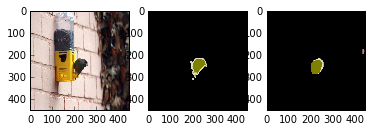

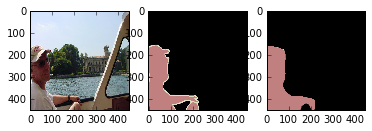

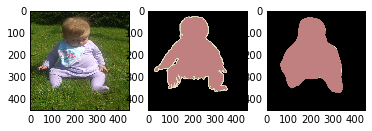

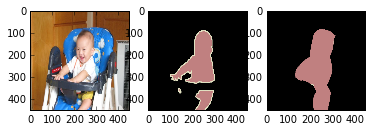

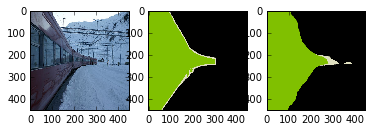

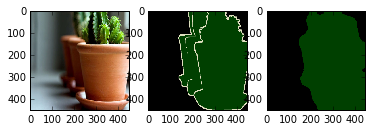

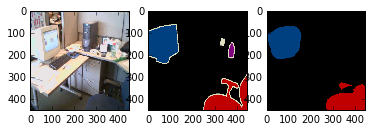

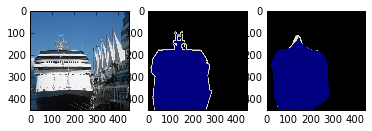

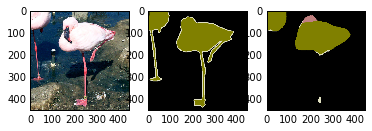

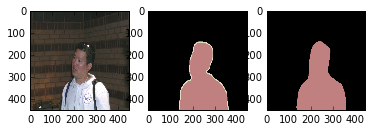

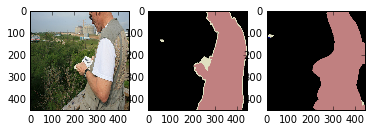

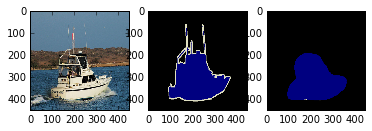

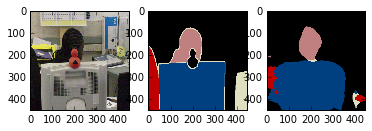

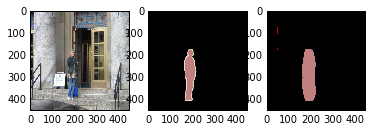

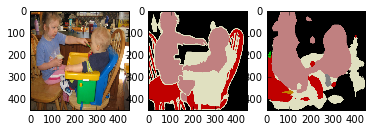

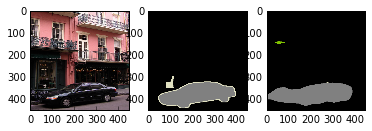

In [123]:
# load test data and 
batch = loader.get_batch(batch_size, 'train')

tensors = [vgg_fcn.pred_up]
feed_dict = {images: batch['images'], labels: batch['seg_labels']}

# forward network to obtain segmentation result
score  = sess.run(tensors, feed_dict=feed_dict)

for bi in range(batch_size):
    plot_result(batch['images'][bi], batch['seg_maps'][bi], score[0][bi], loader.get_palette())

## TEST the model

### Load the checkpoint

In [12]:
# reset the graph and session
tf.reset_default_graph()
sess.close()

In [5]:
batch_size = 7
with tf.variable_scope('inputs') as scope:
    images = tf.placeholder(dtype=tf.float32, 
                            shape=[batch_size, img_size, img_size, 3],
                            name='images')
    labels = tf.placeholder(dtype=tf.int64, 
                            shape=[batch_size, img_size, img_size], 
                            name='labels')

# build FCN
vgg_fcn = fcn_vgg.FCN()
with tf.name_scope("content_vgg"):
    vgg_fcn.build(images, net_type=net_type, train=False, num_classes=22, debug=False)
    
# optimizer
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
lr = tf.train.exponential_decay(lr_params['initial_lr'],
                                global_step,
                                lr_params['decay_step'],
                                lr_params['decay_rate'],
                                staircase=True)
total_loss = get_loss(vgg_fcn.upscore, labels, num_classes)
train_op = tf.train.AdamOptimizer(lr).minimize(total_loss, global_step=global_step)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Automatically find the last checkpoint
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir='fcn_checkpoints/')
#checkpoint_path = 'fcn_checkpoints/cifar10_cnn-3000'
print('Last checkpoint path is %s' % (checkpoint_path))
# Create saver
saver = tf.train.Saver()
if checkpoint_path != '':
    saver.restore(sess, save_path=checkpoint_path)
    print('Model is restored from %s' % checkpoint_path)

Last checkpoint path is fcn_checkpoints/fcn_vgg-4200
Model is restored from fcn_checkpoints/fcn_vgg-4200


### Visualize the result

In [ ]:
loader.reset()

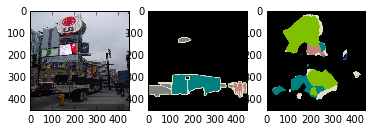

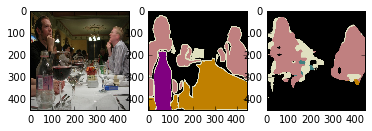

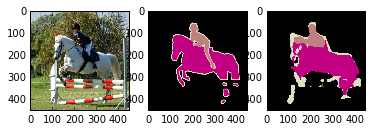

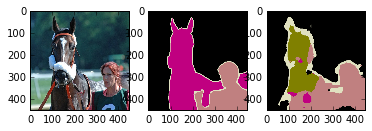

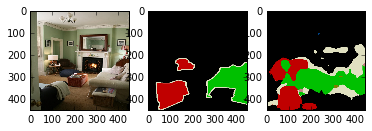

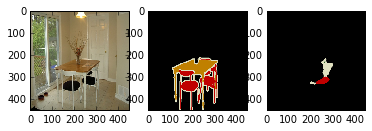

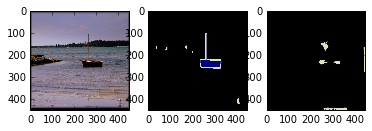

In [10]:
# load test data and 
batch = loader.get_batch(batch_size, 'test')

tensors = [vgg_fcn.pred_up]
feed_dict = {images: batch['images'], labels: batch['seg_labels']}

# forward network to obtain segmentation result
score  = sess.run(tensors, feed_dict=feed_dict)

for bi in range(batch_size):
    plot_result(batch['images'][bi], batch['seg_maps'][bi], score[0][bi], loader.get_palette())

### Compute the accuracy

In [15]:
# Predict segmentation labels for all test examples
# and compute confusion matrix
num_classes = 22
num_iterations = loader.get_num_test_examples() / batch_size
conf_counts = np.zeros((num_classes, num_classes))

loader.reset()
for ii in range(int(num_iterations)):
    # Load a batch data
    batch = loader.get_batch(batch_size, 'test')
    feed_dict = {images: batch['images'], labels: batch['seg_labels']}

    # Run the optimizer
    score = sess.run(vgg_fcn.pred_up, feed_dict=feed_dict)

    # Accumulate confusions
    for bi in range(batch_size):
        # Do not count boundary labels
        loc = np.where(batch['seg_labels'][bi] < 21, True, False)
        # row is gt labels and column is predicted labels
        sumim = batch['seg_labels'][bi] + score[bi] * num_classes
        hs, bin_edge = np.histogram(sumim[loc], np.arange(num_classes*num_classes+1), 
                                    (0, num_classes*num_classes+1))
        conf_counts = conf_counts + np.reshape(hs, (num_classes,num_classes))
    
    # Print the accuracy and loss of current batch data
    if ((ii+1) % 10 == 0) or ((ii+1) == num_iterations):
        print('TEST %d/%d Done' % (ii+1, num_iterations))

TEST 10/207 Done
TEST 20/207 Done
TEST 30/207 Done
TEST 40/207 Done
TEST 50/207 Done
TEST 60/207 Done
TEST 70/207 Done
TEST 80/207 Done
TEST 90/207 Done
TEST 100/207 Done
TEST 110/207 Done
TEST 120/207 Done
TEST 130/207 Done
TEST 140/207 Done
TEST 150/207 Done
TEST 160/207 Done
TEST 170/207 Done
TEST 180/207 Done
TEST 190/207 Done
TEST 200/207 Done
TEST 207/207 Done


In [16]:
# Compute accuracy for all classes and mean accuracy 
acc = np.zeros(num_classes)
for ic in range(num_classes):
    gt1 = np.sum(conf_counts[ic,:])
    res1 = np.sum(conf_counts[:,ic])
    gtlres = conf_counts[ic,ic]
    acc[ic] = 100.0 * gtlres / (gt1 + res1 - gtlres)
    if (ic > 0) and (ic < num_classes-1):
        print('%s IoU %.3f' % (class_names[ic-1], acc[ic]))
print('=============================================')
print('Mean IoU %.3f' % (np.mean(acc[1:num_classes])))

aeroplane IoU 62.299
bicycle IoU 28.578
bird IoU 38.013
boat IoU 35.024
bottle IoU 34.775
bus IoU 61.181
car IoU 57.643
cat IoU 49.179
chair IoU 5.025
cow IoU 30.830
diningtable IoU 19.278
dog IoU 38.455
horse IoU 33.138
motorbike IoU 50.154
person IoU 63.027
potted plant IoU 23.558
sheep IoU 42.264
sofa IoU 24.319
train IoU 51.666
tv/monitor IoU 48.313
Mean IoU 37.939
